- Design Patterns that focus on the interactions and communciation between object. They help define how objects collaborate and distribute responsibility among them, making it easier to manage complex control flow and communicqation in a system.

# 1. Observer Design Pattern (Pub/Sub)
- 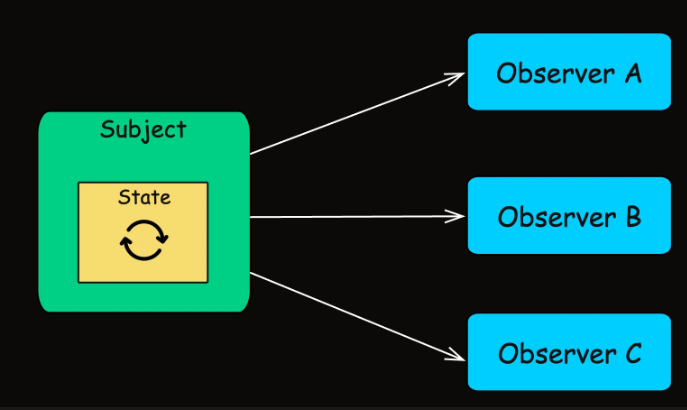
- Defines a one-to-many dependency between objects so that when one object (the subject) chanegs its state, all its dependends (observers) are automatically notified and updated.
- Its useful in
    - We have multiple parts of the system that need to react to a change in one central component.
    - We want to decouple the publisher of data from the subscribers who react to it.
    - We need a dynamic, event-driven communication model without hardcoding who is listening to whom.
- Solves the decouping the subject and its observers, allowing them to interact through a common interface. Observers can be added or removed at runtime, and the subject doen't need to know who they are - just that they implement a specific interface.

### Problem: Broadcasting Fitness Data
- Developing a Fitness Tracker App that connects to a wearable device and receives real time fitness data.
- Whenever new data is received from the device, it gets pushed into a central object and  multiple modeules witing our app need to react to these updates. 

In [3]:
from abc import ABC, abstractmethod

# LiveActivityDisplay
class FitnessDataObserver(ABC):
    @abstractmethod
    def update(self, data):
        pass

# ProgressLogger
class ProgressLoggerNaive:
    def log_data_point(self, steps, active_minutes, calories):
        print(f"NAIVE Logger: Saving data - Steps: {steps}, Active Mins: {active_minutes}, Calories: {calories}")
        # Actual database/file logging logic

# NtificationService
class NotificationServiceNaive:
    def __init__(self):
        self.step_goal = 10000
        self.daily_step_goal_notified = False

    def check_and_notify(self, current_steps):
        if current_steps >= self.step_goal and not self.daily_step_goal_notified:
            print(f"NAIVE Notifier: ALERT! You've reached your {self.step_goal} step goal!")
            self.daily_step_goal_notified = True

    def reset_daily_notifications(self):
        self.daily_step_goal_notified = False

# FitnessDataNaive
class FitnessDataNaive:
    def __init__(self):
        self.steps = 0
        self.active_minutes = 0
        self.calories = 0

        # Direct, hardcoded references to all dependent modules
        # self.live_display = LiveActivityDisplayNaive()
        self.progress_logger = ProgressLoggerNaive()
        self.notification_service = NotificationServiceNaive()

    def new_fitness_data_pushed(self, new_steps, new_active_minutes, new_calories):
        self.steps = new_steps
        self.active_minutes = new_active_minutes
        self.calories = new_calories
        print(f"\nFitnessDataNaive: New data received - Steps: {self.steps}, "
              f"ActiveMins: {self.active_minutes}, Calories: {self.calories}")

        # Manually notify each dependent module
        # self.live_display.show_stats(self.steps, self.active_minutes, self.calories)
        self.progress_logger.log_data_point(self.steps, self.active_minutes, self.calories)
        self.notification_service.check_and_notify(self.steps)

    def daily_reset(self):
        # ResetLogic
        if self.notification_service is not None:
            self.notification_service.reset_daily_notifications()
        print("FitnessDataNaive: Daily data reset.")
        self.new_fitness_data_pushed(0, 0, 0) # Notify with reset stte


def fitness_app_naive_client():
    fitness_data = FitnessDataNaive()
    
    fitness_data.new_fitness_data_pushed(500, 5, 20)
    fitness_data.new_fitness_data_pushed(9800, 85, 350)
    fitness_data.new_fitness_data_pushed(10100, 90, 380)  # Goal should be hit
    fitness_data.daily_reset()

# Example usage
if __name__ == "__main__":
    print("=== Naive Approach ===")
    fitness_app_naive_client()

=== Naive Approach ===

FitnessDataNaive: New data received - Steps: 500, ActiveMins: 5, Calories: 20
NAIVE Logger: Saving data - Steps: 500, Active Mins: 5, Calories: 20

FitnessDataNaive: New data received - Steps: 9800, ActiveMins: 85, Calories: 350
NAIVE Logger: Saving data - Steps: 9800, Active Mins: 85, Calories: 350

FitnessDataNaive: New data received - Steps: 10100, ActiveMins: 90, Calories: 380
NAIVE Logger: Saving data - Steps: 10100, Active Mins: 90, Calories: 380
NAIVE Notifier: ALERT! You've reached your 10000 step goal!
FitnessDataNaive: Daily data reset.

FitnessDataNaive: New data received - Steps: 0, ActiveMins: 0, Calories: 0
NAIVE Logger: Saving data - Steps: 0, Active Mins: 0, Calories: 0


### Observer
- Provides a clean and flexible solution to the problem of broadcasting changes from one central object (the Subject) to many dependent objects (the Observers) - all while keeping them loosely coupled.
- 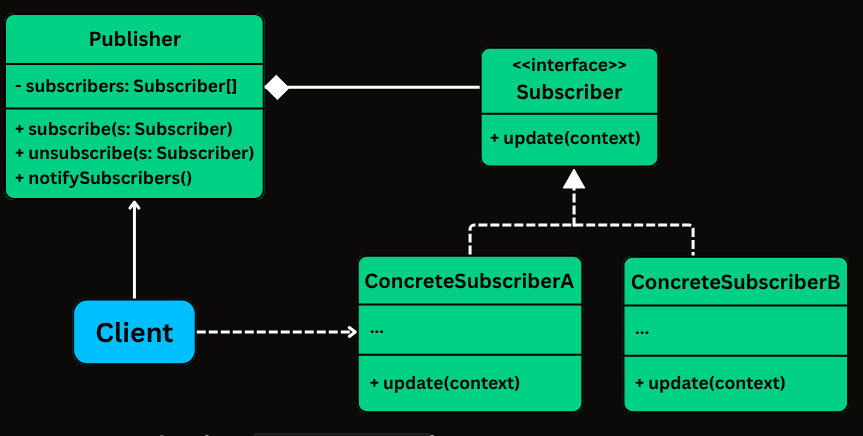

In [7]:
from abc import ABC, abstractmethod

# Observer
class FitnessDataObserver(ABC):
    @abstractmethod
    def update(self, data):
        pass

# Interface
class FitnessDataSubject(ABC):
    @abstractmethod
    def register_observer(self, observer):
        pass

    @abstractmethod
    def remove_observer(self, observer):
        pass

    @abstractmethod
    def notify_observer(self):
        pass

# Concrete Subjet
class FitnessData(FitnessDataSubject):
    def __init__(self):
        self.steps = 0
        self.active_minutes = 0
        self.calories = 0
        self.observers = []

    def register_observer(self, observer):
        self.observers.append(observer)

    def remove_observer(self, observer):
        if observer in self.observers:
            self.observers.remove(observer)

    def notify_observer(self):
        for observer in self.observers:
            observer.update(self)

    def new_fitness_data_pushed(self, steps, active_minutes, calories):
        self.steps = steps
        self.active_minutes = active_minutes
        self.calories = calories
        
        print(f"\nFitnessData: New data received – Steps: {steps}, "
              f"Active Minutes: {active_minutes}, Calories: {calories}")
        
        self.notify_observer()
    
    def daily_reset(self):
        self.steps = 0
        self.active_minutes = 0
        self.calories = 0

        print("\nFintessData: Daily reset performed.")
        self.notify_observer()

    def get_steps(self):
        return self.steps

    def get_active_minutes(self):
        return self.active_minutes

    def get_calories(self):
        return self.calories

# Observer Method
class LiveActivityDisplay(FitnessDataObserver):
    def update(self, data):
        print(f"Live Display → Steps: {data.get_steps()} "
              f"| Active Minutes: {data.get_active_minutes()} "
              f"| Calories: {data.get_calories()}")

class ProgressLonger(FitnessDataObserver):
    def update(self, data):
        print(f"Logger → Saving to DB: Steps={data.get_steps()}, "
              f"ActiveMinutes={data.get_active_minutes()}, "
              f"Calories={data.get_calories()}")

class GoalNotifier(FitnessDataObserver):
    def __init__(self):
        self.step_goal = 10000
        self.goal_reached = False

    def update(self, data):
        if data.get_steps() >= self.step_goal and not self.goal_reached:
            print(f"Notifier → 🎉 Goal Reached! You've hit {self.step_goal} steps!")
            self.goal_reached = True

    def reset(self):
        self.goal_reached = False

# Client
def fitness_app_observer_demo():
    fitness_data = FitnessData()

    display = LiveActivityDisplay()
    logger =  ProgressLonger()
    notifier = GoalNotifier()

    # Register observers
    fitness_data.register_observer(display)
    fitness_data.register_observer(logger)
    fitness_data.register_observer(notifier)

    # Simulate updates
    fitness_data.new_fitness_data_pushed(500, 5, 20)
    fitness_data.new_fitness_data_pushed(9800, 85, 350)
    fitness_data.new_fitness_data_pushed(10100, 90, 380)

    # Daily reset
    notifier.reset()
    fitness_data.daily_reset()


if __name__ == "__main__":

    print("\n\n=== Observer Pattern Approach ===")
    fitness_app_observer_demo()



=== Observer Pattern Approach ===

FitnessData: New data received – Steps: 500, Active Minutes: 5, Calories: 20
Live Display → Steps: 500 | Active Minutes: 5 | Calories: 20
Logger → Saving to DB: Steps=500, ActiveMinutes=5, Calories=20

FitnessData: New data received – Steps: 9800, Active Minutes: 85, Calories: 350
Live Display → Steps: 9800 | Active Minutes: 85 | Calories: 350
Logger → Saving to DB: Steps=9800, ActiveMinutes=85, Calories=350

FitnessData: New data received – Steps: 10100, Active Minutes: 90, Calories: 380
Live Display → Steps: 10100 | Active Minutes: 90 | Calories: 380
Logger → Saving to DB: Steps=10100, ActiveMinutes=90, Calories=380
Notifier → 🎉 Goal Reached! You've hit 10000 steps!

FintessData: Daily reset performed.
Live Display → Steps: 0 | Active Minutes: 0 | Calories: 0
Logger → Saving to DB: Steps=0, ActiveMinutes=0, Calories=0


# 2. Strategy Design Pattern
- 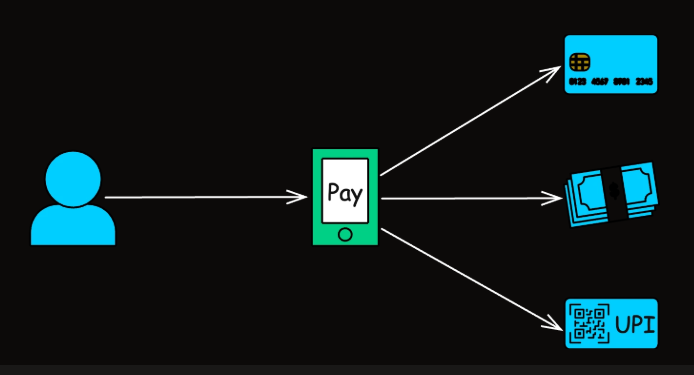
- Les us define a family of algorithms, put each one into a separate class, and makes their objects interchangeable - allowing the algorithm to vary independently from the clients that use it.
- It's useful in
    - We have multiple ways to perform a task or calculation.
    - The behavior of a class needs to change dynamically at runtime.
    - We want to avoid cluttering our code with conditional logic (like if-ele or switch statements) for every variation.
- When we have multiple was to achive the same goal, we migth sue branching logic inside a class to handle different cases. But as more payment types are added, this approach becomes hard to scale, violates open/close principle.
- The Strategy pattern solves this by encapsulating eaach behavior in its own class and delegating the responsibiity to the right strategy at runtime - keeping our core logic clean, extensible, and testable.

### Problem: Shipping Cost calculation
- We're building a shipping cost calculator for an e-commerce platform
- Some common strategies we may need to support:
    - Flat Rate: A fixed fee, regardless of weight or destination
    - Weight-based: Cost is calculated as a fixed amount per kilogram
    - Distance-Based: Different rates depening on destination zones
    - Third-party API: Fetch dynamic rates from providers like FedEx or UPS

### Naive Solution: 
- Implement all the logic inside a single class, using a long chain of conditions.

In [14]:
class ShippingCostCalcylatorNaive:
    def calculate_shipping_cost(self, order, strategy_type):
        cost = 0.0

        if strategy_type.upper() == "FLAT_RATE":
            print("Calculating with Flat Rate strategy.")
            cost = 10.0
        
        elif strategy_type.upper() == "WEIGHT_BASED":
            print("Calculating with Weight-Based strategy.")
            cost = order.get_total_weight() * 2.5
        
        elif strategy_type.upper() == "DISTANCE_BASED":
            print("Calculating with Distance-Based strategy.")
            if order.get_destination_zone() == "ZoneA":
                cost = 5.0
            elif order.get_destination_zone() == "ZoneB":
                cost = 12.0
            else:
                cost = 20.0  # fallback
        
        elif strategy_type.upper() == "THIRD_PARTY_API":
            print("Calculating with Third-Party API strategy.")
            # Simulated external call
            cost = 7.5 + (order.get_order_value() * 0.02)
        
        else:
            raise ValueError(f"Unknown shipping strategy: {strategy_type}")
        
        print(f"Calculated Shipping Cost: ${cost}")
        return cost

class Order:
    def __init__(self, order_value, order_weight, order_zone):
        self.__order_value = order_value
        self.__order_weight = order_weight
        self.__order_zone = order_zone

    def get_order_value(self):
        return self.__order_value

    def get_total_weight(self):
        return self.__order_weight

    def get_destination_zone(self):
        return self.__order_zone

def ecommerce_app_v1():
    calculator = ShippingCostCalcylatorNaive()
    
    print("--- Order 1 ---")
    order1 = Order(4, 51, "ZoneB")
    calculator.calculate_shipping_cost(order1, "FLAT_RATE")
    calculator.calculate_shipping_cost(order1, "WEIGHT_BASED")
    calculator.calculate_shipping_cost(order1, "DISTANCE_BASED")
    calculator.calculate_shipping_cost(order1, "THIRD_PARTY_API")


if __name__ == "__main__":
    print("=== Naive Approach ===")
    ecommerce_app_v1()

=== Naive Approach ===
--- Order 1 ---
Calculating with Flat Rate strategy.
Calculated Shipping Cost: $10.0
Calculating with Weight-Based strategy.
Calculated Shipping Cost: $127.5
Calculating with Distance-Based strategy.
Calculated Shipping Cost: $12.0
Calculating with Third-Party API strategy.
Calculated Shipping Cost: $7.58


- Each shipping strategy to be defined independently
- Easy plug-and-play behavior at runtime
- A design that is open for extension, but closed for modification

### Strategy Pattern
- Defines a family of algorithms, encapsulates each one, and makes them interchangeable.
- Rather than hardcoding logic with if-else or switch statements, we delegate the behavior to strategy objects.
- The pattern allows a client to plug in a specific behavior at runtime without changing the underlying logic of the system.
- 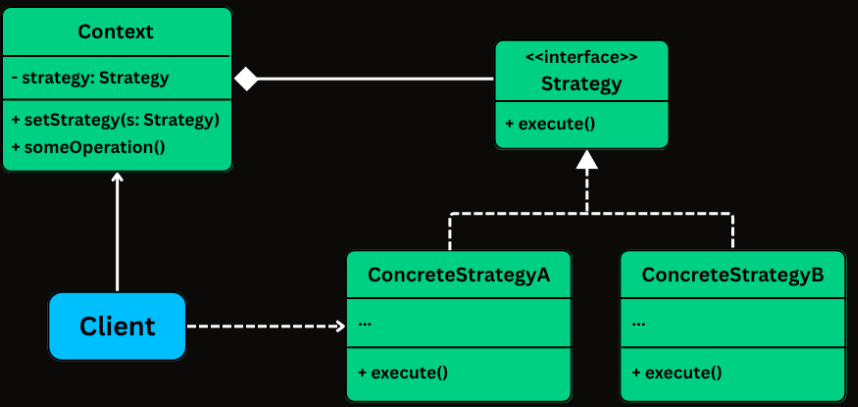

In [18]:
from abc import ABC, abstractmethod

# Strategy Interface
class ShippingStrategy(ABC):
    @abstractmethod
    def calculate_cost(self, order):
        pass

# Concrete Strategy classes
class FlatRateShipping(ShippingStrategy):
    def __init__(self, rate):
        self.rate = rate

    def calculate_cost(self, order):
        print(f"Calculating with flat rate strategy (${self.rate})")
        return self.rate

class WeightBasedShipping(ShippingStrategy):
    def __init__(self, rate_per_kg):
        self.rate_per_kg = rate_per_kg

    def calculate_cost(self, order):
        print(f"Calculating with weight-based strategy (${self.rate_per_kg}/kg)")
        return order.get_total_weight() * self.rate_per_kg

class DistanceBasedShipping(ShippingStrategy):
    def __init__(self, rate_per_km):
        self.rate_per_km = rate_per_km
    
    def calculate_cost(self, order):
        print(f"Calculating with Distance-Based strategy for zone: {order.get_destination_zone()}")
        zone_mapping = {
            "ZoneA": self.rate_per_km * 5.0,
            "ZoneB": self.rate_per_km * 7.0
        }
        return zone_mapping.get(order.get_destination_zone(), self.rate_per_km * 10.0)

class ThirdPartyApiShipping(ShippingStrategy):
    def __init__(self, base_fee, percentage_fee):
        self.base_fee = base_fee
        self.percentage_fee = percentage_fee
    
    def calculate_cost(self, order):
        print("Calculating with Third-Party API strategy.")
        # Simulate API call
        return self.base_fee + (order.get_order_value() * self.percentage_fee)

# Context class

class ShippingCostService:
    def __init__(self, strategy):
        self.strategy = strategy
    
    def set_strategy(self, strategy):
        print(f"ShippingCostService: Strategy changed to {strategy.__class__.__name__}")
        self.strategy = strategy

    def calculate_shipping_cost(self, order):
        if self.strategy is None:
            raise ValueError("Shipping strategy not set.")
        
        cost = self.strategy.calculate_cost(order)
        print(f"ShippingCostService: Final Calculated Shipping Cost: ${cost} "
              f"(using {self.strategy.__class__.__name__})")
        return cost


class Order:
    def __init__(self, order_value, order_weight, order_zone):
        self.__order_value = order_value
        self.__order_weight = order_weight
        self.__order_zone = order_zone

    def get_order_value(self):
        return self.__order_value

    def get_total_weight(self):
        return self.__order_weight

    def get_destination_zone(self):
        return self.__order_zone


# Client
def ecommerce_app_v2():
    order1 = Order(4, 51, "ZoneB")
    
    # Create different strategy instances
    flat_rate = FlatRateShipping(10.0)
    weight_based = WeightBasedShipping(2.5)
    distance_based = DistanceBasedShipping(5.0)
    third_party = ThirdPartyApiShipping(7.5, 0.02)
    
    # Create context with an initial strategy
    shipping_service = ShippingCostService(flat_rate)
    
    print("--- Order 1: Using Flat Rate (initial) ---")
    shipping_service.calculate_shipping_cost(order1)
    
    print("\n--- Order 1: Changing to Weight-Based ---")
    shipping_service.set_strategy(weight_based)
    shipping_service.calculate_shipping_cost(order1)
    
    print("\n--- Order 1: Changing to Distance-Based ---")
    shipping_service.set_strategy(distance_based)
    shipping_service.calculate_shipping_cost(order1)
    
    print("\n--- Order 1: Changing to Third-Party API ---")
    shipping_service.set_strategy(third_party)
    shipping_service.calculate_shipping_cost(order1)

if __name__ == "__main__":
    ecommerce_app_v2()

--- Order 1: Using Flat Rate (initial) ---
Calculating with flat rate strategy ($10.0)
ShippingCostService: Final Calculated Shipping Cost: $10.0 (using FlatRateShipping)

--- Order 1: Changing to Weight-Based ---
ShippingCostService: Strategy changed to WeightBasedShipping
Calculating with weight-based strategy ($2.5/kg)
ShippingCostService: Final Calculated Shipping Cost: $127.5 (using WeightBasedShipping)

--- Order 1: Changing to Distance-Based ---
ShippingCostService: Strategy changed to DistanceBasedShipping
Calculating with Distance-Based strategy for zone: ZoneB
ShippingCostService: Final Calculated Shipping Cost: $35.0 (using DistanceBasedShipping)

--- Order 1: Changing to Third-Party API ---
ShippingCostService: Strategy changed to ThirdPartyApiShipping
Calculating with Third-Party API strategy.
ShippingCostService: Final Calculated Shipping Cost: $7.58 (using ThirdPartyApiShipping)


# 3. Command Design Pattern
- Turns a request into a standalone object, allowing us to parameterize actions, queue them, log them, or support undoable operations - all while decoupling the sender from the receiver.
- Its used for
    - We want to encapsulate operations as objects
    - We need to queue, delay, or log requests
    - We want to support undo/redo functionality
    - We want to decouple the object that invokes an operation from the one that knows how to perform it.

### Problem: The tightly coupled smart home controller
- We're building a "Smart Home Hub" application.
- This hub needs to control various devices
    - Smart lights
    - Thermostats
    - Security systems
    - Smart speakers
    - Garage doors
- The hub should be able to send commands like light.on(), light.off(), thermostat.setTemperature(22), speaker.playMusic()

### Naive Implementation
- One controller to rule them all

In [20]:
class Light:
    def on(self):
        print("Light turned on")

    def off(self):
        print("Light turned off")

class Thermostat:
    def set_temperature(self, temp):
        print(f"Thermostat set to {temp}°C")

# Controller
class SmartHomeControllerV1:
    def __init__(self, light, thermostat):
        self.light = light
        self.thermostat = thermostat

    def turn_on_light(self):
        self.light.on()

    def turn_off_light(self):
        self.light.off()

    def set_thermostat_temperature(self, temperature):
        self.thermostat.set_temperature(temperature)

def main():
    light = Light()
    thermostat = Thermostat()
    controller = SmartHomeControllerV1(light, thermostat)

    controller.turn_on_light()
    controller.set_thermostat_temperature(22)
    controller.turn_off_light()

if __name__ == "__main__":
    main()

Light turned on
Thermostat set to 22°C
Light turned off


### Command Pattern
- Turns a request into a standalone object, allowing us to:
    - Parameterize actions
    - Queue or log operations
    - Support undo/redo
    - Decouple the invoker of an operation from the receiver that performs it
- 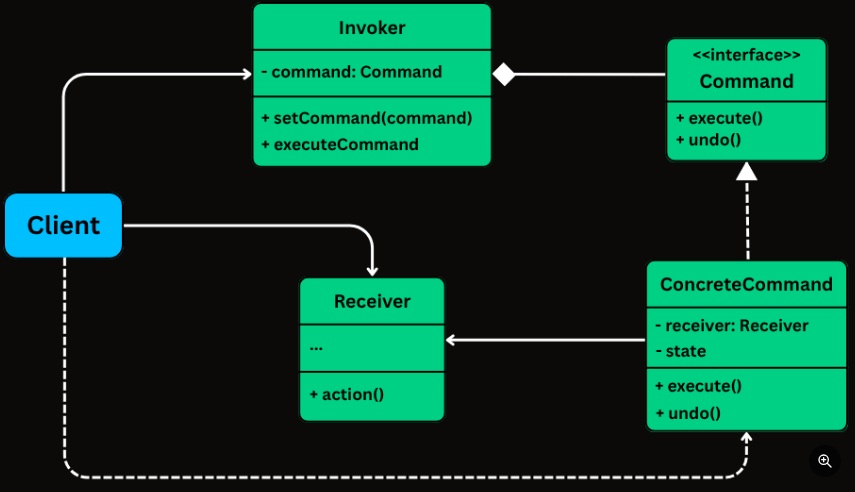
- Each command implements a standard interface like execute() (undo())
- The invoker (e.g remote control, scheduler) simply calls command.execute()
- The Receiver performs the actual operation when the command is executed.

In [21]:
from abc import ABC, abstractmethod

# Comand Interfce
class Command(ABC):
    @abstractmethod
    def execute(self):
        pass

    @abstractmethod
    def undo(self):
        pass

# Receivers (Device)
class Light:
    def on(self):
        print("Light turned ON")

    def off(self):
        print("Light turned OFF")

class Thermostat:
    def __init__(self):
        self.current_temperature = 20  # default

    def set_temperature(self, temp):
        print(f"Thermostat set to {temp}°C")
        self.current_temperature = temp

    def get_current_temperature(self):
        return self.current_temperature

# Concrete command classes
class LightOnCommand(Command):
    def __init__(self, light):
        self.light = light

    def execute(self):
        self.light.on()

    def undo(self):
        self.light.off()

class LightOffCommand(Command):
    def __init__(self, light):
        self.light = light

    def execute(self):
        self.light.off()

    def undo(self):
        self.light.on()

class SetTemperatureCommand(Command):
    def __init__(self, thermostat, temperature):
        self.thermostat = thermostat
        self.new_temperature = temperature
        self.previous_temperature = None

    def execute(self):
        self.previous_temperature = self.thermostat.get_current_temperature()
        self.thermostat.set_temperature(self.new_temperature)

    def undo(self):
        self.thermostat.set_temperature(self.previous_temperature)

# Invoker
class SmartButton:
    def __init__(self):
        self.current_command = None
        self.history = []

    def set_command(self, command):
        self.current_command = command

    def press(self):
        if self.current_command is not None:
            self.current_command.execute()
            self.history.append(self.current_command)
        else:
            print("No command assigned")

    def undo_last(self):
        if self.history:
            last_command = self.history.pop()
            last_command.undo()
        else:
            print("Nothing to undo")

def main():
    # Recivers
    light = Light()
    thermostat = Thermostat()

    # Commands
    light_on = LightOnCommand(light)
    light_off = LightOffCommand(light)
    set_temp22 = SetTemperatureCommand(thermostat, 22)

    # Invoker
    button = SmartButton()

    # Simulate usage
    print("→ Pressing Light ON")
    button.set_command(light_on)
    button.press()

    print("→ Pressing Set Temp to 22°C")
    button.set_command(set_temp22)
    button.press()

    print("→ Pressing Light OFF")
    button.set_command(light_off)
    button.press()

    # Undo sequence
    print("\n↶ Undo Last Action")
    button.undo_last()  # undo Light OFF

    print("↶ Undo Previous Action")
    button.undo_last()  # undo Set Temp

    print("↶ Undo Again")
    button.undo_last()  # undo Light ON

if __name__ == "__main__":
    main()

→ Pressing Light ON
Light turned ON
→ Pressing Set Temp to 22°C
Thermostat set to 22°C
→ Pressing Light OFF
Light turned OFF

↶ Undo Last Action
Light turned ON
↶ Undo Previous Action
Thermostat set to 20°C
↶ Undo Again
Light turned OFF


# 4.Chain of Responsibility Design Pattern
- 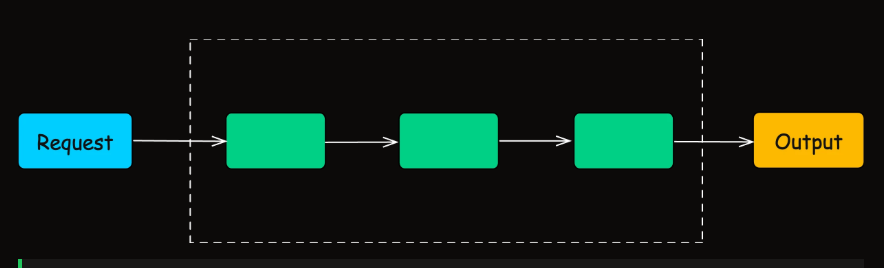
- This lets us pass requests along a chain of handlers, allowing each handler to decide whether to process the requests along a chain of handlers, allowing each handler to decide whether to process the request or pass it to the next handler in the chain.
- Its useful in
    - A request must be handled by one of many possible handlers, and we don't want the sender to be tightly coupled to any specific one.
    - We want to decouple request logic from the code that processes it.
    - We want to flexibly add, remove, or reorder handlers without changing the client code.

### The Problem: Handling HTTP Requests
- We're building a backend server that processes incoming HTTP requests for a web application o RESTful API

In [4]:
class Request:
    def __init__(self, user, user_role, request_count, payload):
        self.user = user
        self.user_role = user_role
        self.request_count = request_count
        self.payload = payload


# Pre-Processing Steps
# Authentication, Authorization, Rate Limiting, Data Validation
class RequestHandler:
    def handle(self, request):
        if not self.authenicate(request):
            print("Request Rejectd: Authentication failed")
            return
        if not self.authorize(request):
            print("Request Rejected: Authorization failed")
            return

        if not self.rate_limit(request):
            print("Request Rejected: Rate limit exceeded.")
            return

        if not self.validate(request):
            print("Request Rejected: Invalid Payload.")
            return

        print("Request passed all checks. Executing business logic...")

    def authenicate(self, req):
        return req.user is not None

    def authorize(self, req):
        return req.user_role == "ADMIN"

    def rate_limit(self, req):
        return req.request_count < 100

    def validate(self, req):
        return req.payload is not None and req.payload != ""

class Request:
    def __init__(self, user, user_role, request_count, payload):
        self.user = user
        self.user_role = user_role
        self.request_count = request_count
        self.payload = payload

# Client
class App:
    @staticmethod
    def main():
        req = Request("john_doe", "ADMIN", 42, "{'data': 123}")
        handler = RequestHandler()
        handler.handle(req)

if __name__ == "__main__":
    App.main()

Request passed all checks. Executing business logic...


### Chain of Responsibility
- The chain of responsibility pattern allows a request to be passed along a chain of handlers.
- Each handler in the chain can either:
    - Handle the request
    - Pass it to the next handler in the chain
- This pattern decouples the sender of the request from the receiver(s), giving us the flexility to compose chains dynamically, reuse logic, and avoid long, rigid conditional blocks.
- 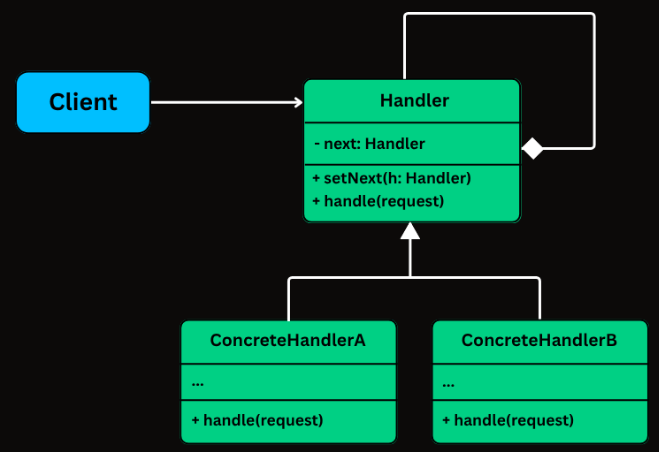

In [9]:
from abc import ABC, abstractmethod

# Common Handler Interface
class RequestHandlerInterface(ABC):
    @abstractmethod
    def set_next(self, next_handler):
        pass

    @abstractmethod
    def handle(self, request):
        pass


# Abstract Base Handler
class BaseHandler(RequestHandlerInterface):
    def __init__(self):
        self.next = None

    def set_next(self, next_handler):
        self.next = next_handler

    def forward(self, request):
        if self.next is not None:
            self.next.handle(request)

# Concrete Handlers
class AuthHandler(BaseHandler):
   def handle(self, request):
       if request.user is None:
           print("AuthHandler: ❌ User not authenticated.")
           return  # Stop the chain
       print("AuthHandler: ✅ Authenticated.")
       self.forward(request)

class AuthorizationHandler(BaseHandler):
   def handle(self, request):
       if request.user_role != "ADMIN":
           print("AuthorizationHandler: ❌ Access denied.")
           return
       print("AuthorizationHandler: ✅ Authorized.")
       self.forward(request)

class RateLimitHandler(BaseHandler):
   def handle(self, request):
       if request.request_count >= 100:
           print("RateLimitHandler: ❌ Rate limit exceeded.")
           return
       print("RateLimitHandler: ✅ Within rate limit.")
       self.forward(request)

class ValidationHandler(BaseHandler):
   def handle(self, request):
       if request.payload is None or request.payload.strip() == "":
           print("ValidationHandler: ❌ Invalid payload.")
           return
       print("ValidationHandler: ✅ Payload valid.")
       self.forward(request)

class BusinessLogicHandler(BaseHandler):
   def handle(self, request):
       print("BusinessLogicHandler: 🚀 Processing request...")
       # Core application logic goes here

class Request:
    def __init__(self, user, user_role, request_count, payload):
        self.user = user
        self.user_role = user_role
        self.request_count = request_count
        self.payload = payload

class RequestHandlerApp:
    @staticmethod
    def main():
        # Create handlers
        auth = AuthHandler()
        authorization = AuthorizationHandler()
        rate_limit = RateLimitHandler()
        validation = ValidationHandler()
        business_logic = BusinessLogicHandler()

        # Build the chain
        auth.set_next(authorization)
        authorization.set_next(rate_limit)
        rate_limit.set_next(validation)
        validation.set_next(business_logic)

        # Send a request through the chain
        request = Request("john", "ADMIN", 10, "{ \"data\": \"valid\" }")
        auth.handle(request)

        print("\n--- Trying an invalid request ---")
        bad_request = Request(None, "USER", 150, "")
        auth.handle(bad_request)

if __name__ == "__main__":
    RequestHandlerApp.main()

AuthHandler: ✅ Authenticated.
AuthorizationHandler: ✅ Authorized.
RateLimitHandler: ✅ Within rate limit.
ValidationHandler: ✅ Payload valid.
BusinessLogicHandler: 🚀 Processing request...

--- Trying an invalid request ---
AuthHandler: ❌ User not authenticated.
